<a href="https://colab.research.google.com/github/Mytros/DS_ML_homework/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_Dmytro_Koval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
sample = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')

In [4]:
sample.shape

(10000, 2)

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/test.csv')

In [6]:
train_df.info(), train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


(None,
    id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
 0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
 1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
 2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
 3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
 4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   
 
      Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
 0       0.00            3.0        1.0             0.0        180626.36   
 1       0.00            2.0        0.0             1.0         63736.17   
 2       0.00            3.0        0.0             0.0        179655.87   
 3   83347.25            2.0        1.0             0.0        161407.48   
 4  107747.57            1.0        1.0             0.0        176580.86   
 
    Exited  
 0     0.0  
 1     0.0  
 2     1.0  
 3     0.0  
 4    

In [7]:
# Train / Validation Split
train_set, val_set = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["Exited"],
    random_state=42
)

# Check
train_shape = train_set.shape, train_set["Exited"].value_counts(normalize=True)
val_shape = val_set.shape, val_set["Exited"].value_counts(normalize=True)

train_shape, val_shape

(((12000, 14),
  Exited
  0.0    0.7965
  1.0    0.2035
  Name: proportion, dtype: float64),
 ((3000, 14),
  Exited
  0.0    0.796667
  1.0    0.203333
  Name: proportion, dtype: float64))

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [8]:
# target
target_col = "Exited"

# inputs
drop_cols = ["id", "CustomerId", "Surname", target_col]
input_cols = [col for col in train_df.columns if col not in drop_cols]

# train / validation check
train_inputs = train_set[input_cols].copy()
train_targets = train_set[target_col].copy()
val_inputs = val_set[input_cols].copy()
val_targets = val_set[target_col].copy()

input_cols, train_inputs.shape, train_targets.shape

(['CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 (12000, 10),
 (12000,))

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [9]:
# numeric / categorical split
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

In [10]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [11]:
train_inputs[categorical_cols].nunique()

,0
Geography,3
Gender,2


In [12]:
train_inputs[numeric_cols].isna().sum()

,0
CreditScore,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [13]:
val_inputs[numeric_cols].isna().sum()

,0
CreditScore,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [14]:
# Scaler
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [15]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [16]:
# Simple imputer
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(train_inputs[numeric_cols])

SimpleImputer()

In [17]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

In [18]:
#Enoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [19]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [20]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])



In [21]:
display(train_inputs.head())
display(val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,0.0,1.0
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,0.0,1.0
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,1.0,0.0
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,1.0,0.0
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [22]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 15)
train_targets: (12000,)
val_inputs: (3000, 15)
val_targets: (3000,)


In [23]:
!pip install pyarrow --quiet

In [24]:
os.listdir('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3')

['test.csv',
 'train.csv',
 'submission_log_reg.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet',
 'sample_submission.csv']

In [25]:
folder = '/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/'

In [26]:
train_inputs.to_parquet(os.path.join(folder, 'train_inputs.parquet'))
val_inputs.to_parquet(os.path.join(folder, 'val_inputs.parquet'))

In [27]:
%%time
pd.DataFrame(train_targets).to_parquet(os.path.join(folder, 'train_targets.parquet'))
pd.DataFrame(val_targets).to_parquet(os.path.join(folder, 'val_targets.parquet'))

CPU times: user 12.5 ms, sys: 4.22 ms, total: 16.7 ms
Wall time: 432 ms


In [28]:
%%time

train_inputs = pd.read_parquet(os.path.join(folder, 'train_inputs.parquet'))
val_inputs = pd.read_parquet(os.path.join(folder, 'val_inputs.parquet'))

train_targets = pd.read_parquet(os.path.join(folder, 'train_targets.parquet'))[target_col]
val_targets = pd.read_parquet(os.path.join(folder, 'val_targets.parquet'))[target_col]


CPU times: user 45.5 ms, sys: 14.3 ms, total: 59.7 ms
Wall time: 133 ms


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [29]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [30]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


In [31]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [32]:
print(X_train)

       CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
7180      0.599045  0.214286     0.1  0.626382       0.000000        1.0   
10393     0.603819  0.375000     0.2  0.848836       0.000000        1.0   
80        0.653938  0.303571     0.6  0.554522       0.333333        1.0   
3365      0.568019  0.714286     0.0  0.000000       0.333333        0.0   
12236     0.658711  0.053571     0.3  0.000000       0.333333        1.0   
...            ...       ...     ...       ...            ...        ...   
9493      0.482100  0.267857     0.4  0.000000       0.333333        0.0   
8463      0.577566  0.392857     0.1  0.000000       0.000000        1.0   
8143      0.453461  0.196429     0.8  0.000000       0.333333        1.0   
11512     0.379475  0.428571     0.7  0.000000       0.333333        0.0   
9360      0.272076  0.160714     0.2  0.000000       0.333333        1.0   

       IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
7180    

In [33]:
model.coef_.round(2)

array([[-0.87,  8.45, -0.08, -1.1 , -3.93, -0.19, -1.25,  0.19, -0.96,
         0.61, -1.05, -0.27, -1.13]])

In [34]:
print(model.coef_.tolist())

[[-0.8727057654948849, 8.451461197130401, -0.07507593826903385, -1.095227113484121, -3.934637049980205, -0.18752677354595151, -1.2534613460000872, 0.18932980315740233, -0.9601551360076453, 0.6079395180143473, -1.0533218301540488, -0.2721184810439519, -1.1334189671031802]]


In [35]:
print(model.intercept_)

[-1.40553745]


In [36]:
train_preds = model.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
train_targets

,Exited
7180,0.0
10393,0.0
80,0.0
3365,0.0
12236,0.0
...,...
9493,0.0
8463,0.0
8143,0.0
11512,0.0


In [38]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.98535823, 0.01464177],
       [0.72907259, 0.27092741],
       [0.87240654, 0.12759346],
       ...,
       [0.9927604 , 0.0072396 ],
       [0.83156063, 0.16843937],
       [0.94951586, 0.05048414]])

In [39]:
np.argmax(train_probs, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

(array([6333., 1943.,  916.,  616.,  481.,  414.,  316.,  319.,  360.,
         302.]),
 array([0.00141861, 0.10051377, 0.19960893, 0.29870408, 0.39779924,
        0.49689439, 0.59598955, 0.6950847 , 0.79417986, 0.89327501,
        0.99237017]),
 <BarContainer object of 10 artists>)

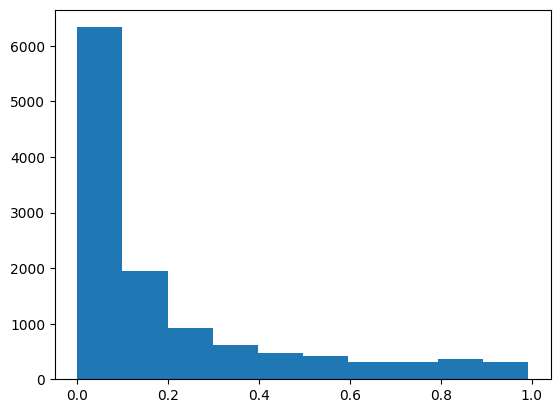

In [40]:
plt.hist(train_probs[:,1])

In [41]:
train_targets.value_counts(normalize=True)

,proportion
Exited,
0.0,0.7965
1.0,0.2035


In [42]:
model.classes_

array([0., 1.])

In [43]:
accuracy_score(train_targets, train_preds)

0.87425

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [44]:
confusion_matrix(train_targets, train_preds)

array([[9177,  381],
       [1128, 1314]])

In [45]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.42%


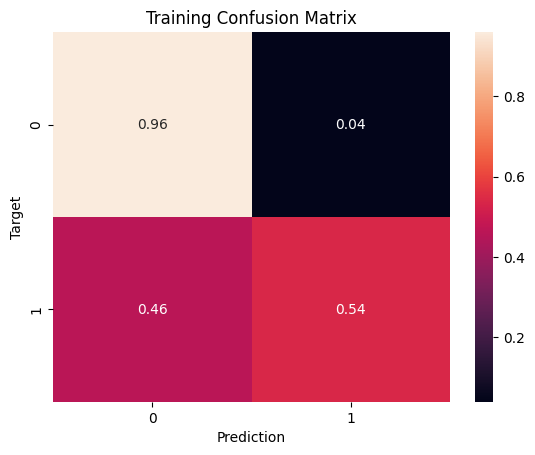

In [46]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.17%


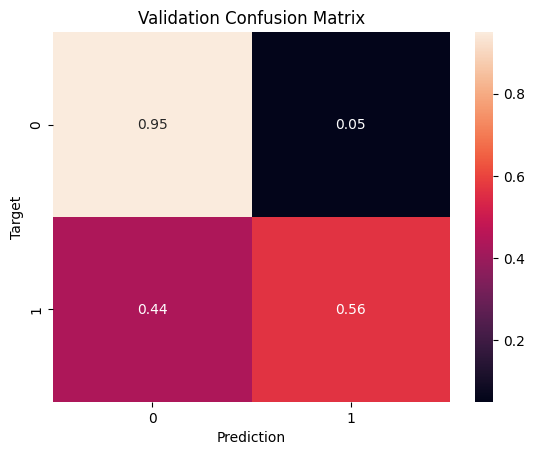

In [47]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Якість моделі - хороша.

In [48]:
preds = model.predict(X_train)
preds[:5], train_targets[:5]

(array([0., 0., 0., 0., 0.]),
 7180     0.0
 10393    0.0
 80       0.0
 3365     0.0
 12236    0.0
 Name: Exited, dtype: float64)

In [49]:
f1_score(train_targets, preds)

0.6352429296591733

In [50]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds) # pos_label='Yes'
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


In [51]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba) # pos_label='Yes'

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.6f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.882389


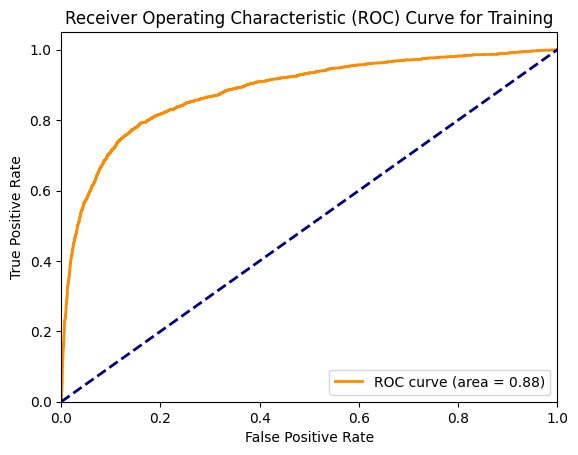

AUROC for Validation: 0.879671


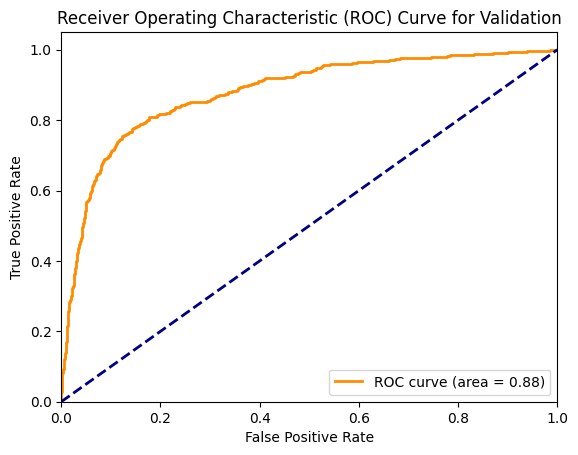

In [52]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [55]:
majority_class = train_targets.mode()[0]
train_majority_preds = np.full_like(train_targets, fill_value=majority_class)
val_majority_preds = np.full_like(val_targets, fill_value=majority_class)

# 3. Accuracy major model
train_majority_acc = accuracy_score(train_targets, train_majority_preds)
val_majority_acc = accuracy_score(val_targets, val_majority_preds)


# comparison
{
    "Majority Class (Train)": round(train_majority_acc, 3),
    "Majority Class (Val)": round(val_majority_acc, 3),
}

{'Majority Class (Train)': 0.796, 'Majority Class (Val)': 0.797}

In [56]:
accuracy_score_train = accuracy_score(train_targets, train_preds)
accuracy_score_val = accuracy_score(val_targets, val_preds)

print('Train accuracy:', round(accuracy_score_train, 3))
print('Validation accuracy:', round(accuracy_score_val, 3))

Train accuracy: 0.874
Validation accuracy: 0.872


Висновок:

Логістична регресія має більшу точність (87% проти ~80%).
F1 Score = 0.641 — означає, що модель вміє не лише правильно виявляти “нульовий” клас, а й визначати клас 1, на відмінну від "мажоритарної" моделі.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [57]:
log_reg = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [58]:
joblib.dump(log_reg, '/content/drive/MyDrive/DS_ML/models/log_reg.joblib')

['/content/drive/MyDrive/DS_ML/models/log_reg.joblib']

In [59]:
model_2 = joblib.load('/content/drive/MyDrive/DS_ML/models/log_reg.joblib')

In [60]:
train_preds2 = model_2['model'].predict(X_train)
accuracy_score(train_targets, train_preds2)

0.87425

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [61]:
import warnings
warnings.filterwarnings("ignore")

''' Original
def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob
'''

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    #global model, imputer  # !!!!
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    encoded_arr = encoder.transform(input_df[categorical_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    encoded_df = pd.DataFrame(encoded_arr, columns=encoded_cols, index=input_df.index)

    #X_input = input_df[numeric_cols + encoded_cols]
    X_input = pd.concat([input_df[numeric_cols], encoded_df], axis=1)
    prob = model.predict_proba(X_input)[:, 1]
    return prob




In [62]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, train_df[:5])

array([0.00654092, 0.0366679 , 0.37111937, 0.37653484, 0.97577854])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [63]:
test_raw_df = test_df

# drop
input_cols = [col for col in test_raw_df.columns if col not in ["id", "CustomerId", "Surname"]]

# copy input
input_data = test_raw_df[input_cols].copy()

predicted_probs = predict_raw_df(scaler=scaler, encoder=encoder, numeric_cols=numeric_cols, categorical_cols=categorical_cols, input_df=input_data)

test_raw_df["Exited"] = predicted_probs

test_raw_df[["Exited"]].head()

,Exited
0,0.075316
1,0.035366
2,0.153210
3,0.194872
4,0.055660


In [ ]:
test_raw_df.shape

(10000, 14)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [64]:
sample_submission = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')

submission_df = sample_submission.copy()
submission_df["Exited"] = test_raw_df["Exited"]
submission_df.head()


,id,Exited
0,15000,0.075316
1,15001,0.035366
2,15002,0.153210
3,15003,0.194872
4,15004,0.055660


In [65]:
submission_df.to_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/submission_log_reg.csv', index=False)
